# Overparameterization of deep ResNet: zero loss and mean-field analysis
## Ding, Chen, Li, Wright 2021

In [2]:
import matplotlib.pyplot as plt
import torch
from torchtyping import TensorType

In [3]:
D = 5
K = 2*D + 1
M = 10
MAX_LOG_L = 10

In [4]:
gaussian = torch.normal(0,1,size=(M,2**MAX_LOG_L,K))
wiener = torch.cumsum(gaussian, axis=1)/2**MAX_LOG_L
theta = gaussian
theta.requires_grad = True

In [5]:
def f(z: TensorType["b", "d"], theta: TensorType["k"]):
    W, U, b = theta[:D], theta[D:2*D], theta[2*D]
    return torch.einsum("d, b -> b d", U, torch.relu(torch.einsum("d, b d -> b", W, z) + b))

In [6]:
def F(z: TensorType["b", "d"], t: int):
    return sum(f(z, theta[m, t]) for m in range(M))/M

In [7]:
def z_recursive(l: int, LOG_L: int, x: TensorType["b", "d"]):
    if l == 0:
        return x
    else:
        prev_z = z_recursive(l-1, L, x)
        return prev_z + F(prev_z, i*2**(MAX_LOG_L-LOG_L))/2**LOG_L

In [8]:
def z_iterative(l: int, LOG_L: int, x: TensorType["b", "d"]):
    z = x
    for i in range(l):
       z = z + F(z, i*2**(MAX_LOG_L-LOG_L))/2**LOG_L 
    return z

In [9]:
def z(LOG_L: int, x: TensorType["b", "d"]):
    return z_iterative(2**LOG_L, LOG_L, x)

In [10]:
B = 100
x = torch.normal(0,1,size=(B,D))

In [11]:
h = 1000
for i in range(10):
    theta.grad = None
    y = z(MAX_LOG_L, x)
    loss = torch.nn.functional.mse_loss(y, x*x)
    print(loss)
    loss.backward()
    with torch.no_grad():
        theta -= h*theta.grad

tensor(3.2845, grad_fn=<MseLossBackward>)
tensor(3.1083, grad_fn=<MseLossBackward>)
tensor(2.9584, grad_fn=<MseLossBackward>)
tensor(2.8263, grad_fn=<MseLossBackward>)
tensor(2.7074, grad_fn=<MseLossBackward>)
tensor(2.5989, grad_fn=<MseLossBackward>)
tensor(2.4994, grad_fn=<MseLossBackward>)
tensor(2.4079, grad_fn=<MseLossBackward>)
tensor(2.3241, grad_fn=<MseLossBackward>)
tensor(2.2479, grad_fn=<MseLossBackward>)


In [12]:
Zs = [z(i,x) for i in range(MAX_LOG_L)]

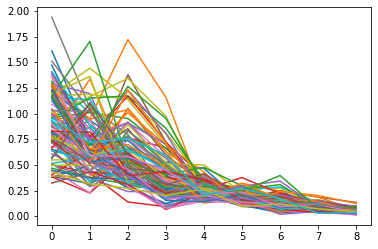

In [13]:
plt.plot([[torch.linalg.norm(Zs[i][k]-Zs[i-1][k]) for k in range(B)] for i in range(1,len(Zs))])
plt.show()